# Tokenizer config 作成（inchi-atoms-numbers）

In [1]:
import json
import tempfile
from pathlib import Path
from pprint import pprint

import pandas as pd
import tokenizers
from rdkit import Chem
from tqdm.auto import tqdm

from nncomp_molecule import constants

tqdm.pandas()

## Config

In [2]:
TOKENIZER_NAME = "inchi-atoms-numbers"
OUTDIR = constants.INPUTDIR / "kfujikawa/bms-tokenizers-v1"
OUTDIR

PosixPath('/work/input/kfujikawa/bms-molecular-translation-tokenizers')

## Tokenizer作成

### Tokenizer configの作成

In [3]:
tokenizer = tokenizers.Tokenizer(
    tokenizers.models.BPE(),
)
tokenizer.add_special_tokens(["<PAD>", "<BOS>", "<EOS>", "<UNK>"])
tokenizer.post_processor = tokenizers.processors.TemplateProcessing(
    single="<BOS> $0 <EOS>",
    special_tokens=[("<BOS>", 1), ("<EOS>", 2)]
)
tokenizer.decoder = tokenizers.decoders.BPEDecoder()

with tempfile.TemporaryDirectory() as tempdir:
    outpath = Path(tempdir) / "tokenizer.json"
    tokenizer.save(str(outpath))
    with open(outpath) as f:
        tokenizer_config = json.load(f)
        
tokenizer_config

{'version': '1.0',
 'truncation': None,
 'padding': None,
 'added_tokens': [{'id': 0,
   'special': True,
   'content': '<PAD>',
   'single_word': False,
   'lstrip': False,
   'rstrip': False,
   'normalized': False},
  {'id': 1,
   'special': True,
   'content': '<BOS>',
   'single_word': False,
   'lstrip': False,
   'rstrip': False,
   'normalized': False},
  {'id': 2,
   'special': True,
   'content': '<EOS>',
   'single_word': False,
   'lstrip': False,
   'rstrip': False,
   'normalized': False},
  {'id': 3,
   'special': True,
   'content': '<UNK>',
   'single_word': False,
   'lstrip': False,
   'rstrip': False,
   'normalized': False}],
 'normalizer': None,
 'pre_tokenizer': None,
 'post_processor': {'type': 'TemplateProcessing',
  'single': [{'SpecialToken': {'id': '<BOS>', 'type_id': 0}},
   {'Sequence': {'id': 'A', 'type_id': 0}},
   {'SpecialToken': {'id': '<EOS>', 'type_id': 0}}],
  'pair': [{'Sequence': {'id': 'A', 'type_id': 0}},
   {'Sequence': {'id': 'B', 'type_id': 

## 辞書作成

### ベース辞書作成

In [4]:
vocab = {
    k: i for i, k in enumerate([
         "<PAD>", "<BOS>", "<EOS>", "<UNK>",
        *'()+,-/=BCDFHINOPSTbchilmnrst',
    ])
}
merges = []
print(f"vocab:\n{json.dumps(vocab)}")
print(f"merges:\n{json.dumps(merges)}")

vocab:
{"<PAD>": 0, "<BOS>": 1, "<EOS>": 2, "<UNK>": 3, "(": 4, ")": 5, "+": 6, ",": 7, "-": 8, "/": 9, "=": 10, "B": 11, "C": 12, "D": 13, "F": 14, "H": 15, "I": 16, "N": 17, "O": 18, "P": 19, "S": 20, "T": 21, "b": 22, "c": 23, "h": 24, "i": 25, "l": 26, "m": 27, "n": 28, "r": 29, "s": 30, "t": 31}
merges:
[]


### 複数文字の辞書登録

In [5]:
tokens = [
    "InChI=1S/",
    "Br", "Cl", "Si",
    "/c", "/h", "/t", "/m", "/s", "/b", "/i",
    *map(str, range(100)),
]

for token in tokens:
    for i in range(len(token)):
        # vocabへの登録
        if token[:i+1] not in vocab:
            vocab[token[:i+1]] = len(vocab)
        # mergesへの登録
        if i > 0:
            merges_text = f"{token[:i]} {token[i]}"
            if merges_text not in merges:
                merges.append(merges_text)

print(f"vocab:\n{json.dumps(vocab)}")
print(f"merges:\n{json.dumps(merges)}")
print(len(vocab))

vocab:
{"<PAD>": 0, "<BOS>": 1, "<EOS>": 2, "<UNK>": 3, "(": 4, ")": 5, "+": 6, ",": 7, "-": 8, "/": 9, "=": 10, "B": 11, "C": 12, "D": 13, "F": 14, "H": 15, "I": 16, "N": 17, "O": 18, "P": 19, "S": 20, "T": 21, "b": 22, "c": 23, "h": 24, "i": 25, "l": 26, "m": 27, "n": 28, "r": 29, "s": 30, "t": 31, "In": 32, "InC": 33, "InCh": 34, "InChI": 35, "InChI=": 36, "InChI=1": 37, "InChI=1S": 38, "InChI=1S/": 39, "Br": 40, "Cl": 41, "Si": 42, "/c": 43, "/h": 44, "/t": 45, "/m": 46, "/s": 47, "/b": 48, "/i": 49, "0": 50, "1": 51, "2": 52, "3": 53, "4": 54, "5": 55, "6": 56, "7": 57, "8": 58, "9": 59, "10": 60, "11": 61, "12": 62, "13": 63, "14": 64, "15": 65, "16": 66, "17": 67, "18": 68, "19": 69, "20": 70, "21": 71, "22": 72, "23": 73, "24": 74, "25": 75, "26": 76, "27": 77, "28": 78, "29": 79, "30": 80, "31": 81, "32": 82, "33": 83, "34": 84, "35": 85, "36": 86, "37": 87, "38": 88, "39": 89, "40": 90, "41": 91, "42": 92, "43": 93, "44": 94, "45": 95, "46": 96, "47": 97, "48": 98, "49": 99, 

## Configの保存

In [6]:
tokenizer_config["model"]["merges"] = merges
tokenizer_config["model"]["vocab"] = vocab
with open(OUTDIR / f"{TOKENIZER_NAME}.json", "w") as f:
    json.dump(tokenizer_config, f)

## 検証

In [7]:
tokenizer = tokenizers.Tokenizer.from_file(str(OUTDIR / f"{TOKENIZER_NAME}.json"))
train_df = pd.read_csv(constants.COMPETITION_DATADIR / "train_labels.csv")
train_df.head()

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


In [8]:
index = 0

inchi = train_df.InChI[index]
print(inchi)
encoding = tokenizer.encode(inchi)
json.dumps(encoding.tokens)

InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12(13)11(4)14/h5-7,9,11,14H,8H2,1-4H3


'["<BOS>", "InChI=1S/", "C", "13", "H", "20", "O", "S", "/c", "1", "-", "9", "(", "2", ")", "8", "-", "15", "-", "13", "-", "6", "-", "5", "-", "10", "(", "3", ")", "7", "-", "12", "(", "13", ")", "11", "(", "4", ")", "14", "/h", "5", "-", "7", ",", "9", ",", "11", ",", "14", "H", ",", "8", "H", "2", ",", "1", "-", "4", "H", "3", "<EOS>"]'

In [9]:
json.dumps(tokenizer.encode("c-123").tokens)

'["<BOS>", "c", "-", "12", "3", "<EOS>"]'

279

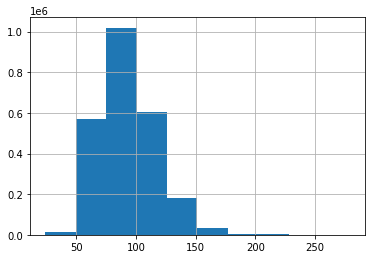

In [10]:
n_tokens = train_df.InChI.progress_apply(lambda x: len(tokenizer.encode(x).tokens))
n_tokens.hist()
n_tokens.max()